# Lab 1 - Sachin, Ikenna, Edgar, Dustin

## Business Understanding

Our selected dataset is a labeled collection of inpatient medical claims, non-personally identifiable beneficiary data, and a list of providers who have been suspected as filing fraudulent claims.  Detecting fraudulent claims is a request frequently asked by a great many organizations in the healthcare industry (and especially in insurance), and claim data is readily available at many of these organizations, so it stands to reason that we may be able to predict fraudulent behavior by analyzing a large number of medical claims.  We will analyze over 40,000 medical claims, non-personally identifying beneficiary information and provider IDs who have previously been identified as engaging in suspected fraudulent behavior in order to attempt to predict possible fraudulent behavior in new claims.

Because we have a categorical response variable, we'll need to treat this as a classification problem.  We will predict possible fraudulent claims and measure effectiveness using cross validation and focus on attaining high metrics in precision and recall.  Precision measures the percentage of fraudulent predictions which are truly fraudulent, and recall measures the total percentage of fraudulent claims correctly identified.  These two metrics have been identified as most appropriate, due to our objective of correctly identifying fraudulent claims.

Some potential outcomes of using this dataset are potentially improving viability of existing provider fraud detection mechanisms in insurance and member paid claims.  Knowledge of fraudulent or excessive billed services awareness for what is or is not acceptable can save money and help reduce rising healthcare costs due to rising insurance premiums.

## ETL

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


#Read in data:
ipdata = pd.read_csv("./data/Train_Inpatientdata-1542865627584.csv")
bendata = pd.read_csv("./data/Train_Beneficiarydata-1542865627584.csv")
prodata = pd.read_csv("./data/Train-1542865627584.csv")


proc_codes = pd.read_csv("./data/CMS27_DESC_LONG_SHORT_SG_092709.csv")
# v27 ICD-9 Procedure Code Data comes from https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/Downloads/FY2010Diagnosis-ProcedureCodesFullTitles.zip

diag_codes = pd.read_fwf("./data/V26 I-9 Diagnosis.txt")
# v26 Diag Code Data comes from https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/Downloads/v27_icd9.zip
# and missing code 7889 comes from https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/Downloads/v26_icd9.zip



# Merge beneficiary data with inpatient data:
ipdata = ipdata.merge(bendata, left_on='BeneID', right_on='BeneID')

# Merge Provider Data:
ipdata = ipdata.merge(prodata, on='Provider', how='inner')

# Fill NAs
ipdata['DOD'] = ipdata['DOD'].fillna('2199-12-31')
missing_vcols = ['OperatingPhysician', 'OtherPhysician','ClmAdmitDiagnosisCode','DiagnosisGroupCode', 
                 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
                 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 
                 'ClmDiagnosisCode_10','ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 
                 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6'] 

ipdata[missing_vcols] = ipdata[missing_vcols].fillna('None')
ipdata['DeductibleAmtPaid'] = ipdata['DeductibleAmtPaid'].fillna(0)



# Convert everythign to string
ipdata = ipdata.applymap(str)

# Convert to usable formats:
timecols = ['ClaimStartDt', 'ClaimEndDt','AdmissionDt', 'DischargeDt', 'DOB','DOD']
numcols = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid','IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt']
catcols = ['PotentialFraud']
intcols = ['ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart','ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov']

ipdata[timecols] = ipdata[timecols].apply(pd.to_datetime)

ipdata['DOD'] = ipdata['DOD'].apply(dt.datetime.toordinal)
ipdata['DOB'] = ipdata['DOB'].apply(dt.datetime.toordinal)
ipdata['ClaimStartDt'] = ipdata['ClaimStartDt'].apply(dt.datetime.toordinal)
ipdata['ClaimEndDt'] = ipdata['ClaimEndDt'].apply(dt.datetime.toordinal)
ipdata['AdmissionDt'] = ipdata['AdmissionDt'].apply(dt.datetime.toordinal)
ipdata['DischargeDt'] = ipdata['DischargeDt'].apply(dt.datetime.toordinal)

ipdata[intcols] = ipdata[intcols].astype(int)

ipdata = ipdata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

ipdata = ipdata.replace({'RenalDiseaseIndicator': 'Y'}, 1)


ipdata[numcols] = ipdata[numcols].astype(float)
ipdata[catcols] = ipdata[catcols].astype('category')


ipdata = ipdata.drop(columns=['OPAnnualReimbursementAmt','OPAnnualDeductibleAmt'])

ipdata.info()

ipdata['ChronicCond_Alzheimer']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40474 entries, 0 to 40473
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   BeneID                           40474 non-null  object  
 1   ClaimID                          40474 non-null  object  
 2   ClaimStartDt                     40474 non-null  int64   
 3   ClaimEndDt                       40474 non-null  int64   
 4   Provider                         40474 non-null  object  
 5   InscClaimAmtReimbursed           40474 non-null  float64 
 6   AttendingPhysician               40474 non-null  object  
 7   OperatingPhysician               40474 non-null  object  
 8   OtherPhysician                   40474 non-null  object  
 9   AdmissionDt                      40474 non-null  int64   
 10  ClmAdmitDiagnosisCode            40474 non-null  object  
 11  DeductibleAmtPaid                40474 non-null  float64 
 12  Disc

0        1
1        1
2        0
3        0
4        1
        ..
40469    1
40470    0
40471    1
40472    0
40473    0
Name: ChronicCond_Alzheimer, Length: 40474, dtype: int64

## Logistic Regression

Accuracy: 0.6017786561264822
Precision: 0.6017786561264822
Recall: 1.0


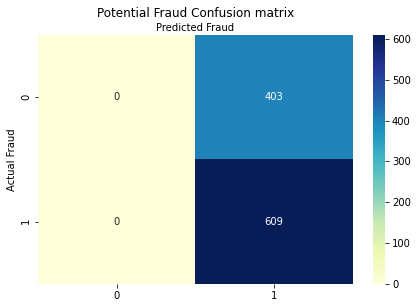

In [7]:
# One hot encode 
df = ipdata.sample(frac=0.1, replace=False, random_state=1)
df = pd.get_dummies(df)
df = df.drop(columns='PotentialFraud_No')

X = df.drop(columns='PotentialFraud_Yes')
Y = df["PotentialFraud_Yes"]

# Logistic Regression Code from: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

# instantiate the model (using the default parameters)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# Build predictions:
#y_pred=logreg.predict(X_test)
y_pred=logreg.predict_proba(X_test)[:,1] > .5


# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Potential Fraud Confusion matrix', y=1.1)
plt.ylabel('Actual Fraud')
plt.xlabel('Predicted Fraud')

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))



In [ ]:

#logreg.predict_proba(X_test)[:,1]

In [ ]:
# Cross Validation
# Code from: https://medium.com/@lily_su/logistic-regression-accuracy-cross-validation-58d9eb58d6e6
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

In [ ]:
ipdata.groupby('PotentialFraud').nunique('ClaimID')

## Feature Importance

In [15]:
ipdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40474 entries, 0 to 40473
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   BeneID                           40474 non-null  object  
 1   ClaimID                          40474 non-null  object  
 2   ClaimStartDt                     40474 non-null  int64   
 3   ClaimEndDt                       40474 non-null  int64   
 4   Provider                         40474 non-null  object  
 5   InscClaimAmtReimbursed           40474 non-null  float64 
 6   AttendingPhysician               40474 non-null  object  
 7   OperatingPhysician               40474 non-null  object  
 8   OtherPhysician                   40474 non-null  object  
 9   AdmissionDt                      40474 non-null  int64   
 10  ClmAdmitDiagnosisCode            40474 non-null  object  
 11  DeductibleAmtPaid                40474 non-null  float64 
 12  Disc

,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,...,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt
0,26000.0,PHY390922,None,None,733509,7866,1068.0,733515,201,1970,...,0,0,1,1,1,0,1,1,36000.0,3204.0
1,19000.0,PHY349293,PHY370861,PHY363291,733427,45340,1068.0,733439,987,4240,...,0,1,0,0,1,0,0,0,19000.0,1068.0
2,17000.0,PHY334706,PHY334706,None,733697,V5789,1068.0,733715,941,V5789,...,0,0,0,0,1,1,0,0,17000.0,1068.0
3,13000.0,PHY390614,PHY323689,PHY363291,733705,71946,1068.0,733709,506,71535,...,0,1,0,1,1,1,1,0,27000.0,2136.0
4,3000.0,PHY380413,PHY432598,None,733415,1748,1068.0,733419,593,2330,...,1,0,0,0,1,0,0,0,3000.0,1068.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,12000.0,PHY319644,PHY319644,PHY403799,733582,78097,1068.0,733589,940,78079,...,1,0,0,1,1,0,1,1,20000.0,2136.0
40470,5000.0,PHY407588,PHY311768,PHY311768,733656,486,1068.0,733663,190,486,...,0,1,1,1,1,0,0,1,5000.0,1068.0
40471,14000.0,PHY409302,None,None,733726,4280,1068.0,733734,308,42821,...,0,1,1,1,1,0,1,0,26790.0,2136.0
40472,10000.0,PHY367360,PHY367360,None,733430,7823,1068.0,733430,238,41071,...,1,1,0,1,1,0,0,0,10300.0,1068.0


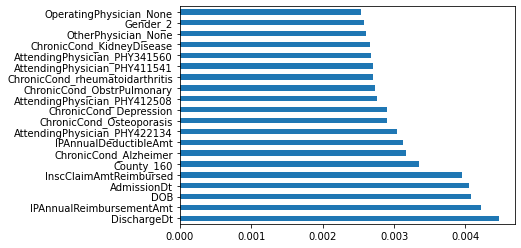

48.66084445999991

In [20]:
#Feature Importance
import timeit
df1 = ipdata.iloc[:,5:53]
start_time = timeit.default_timer()

#.0001 = .333
#.001 = .349
#.01 = .639
#.1 = 22.56
#.2 = 78.74

#df = ipdata
df = df1.sample(frac=0.15, replace=False, random_state=1)
df = pd.get_dummies(df)
#df = df.drop(columns='PotentialFraud_No')



X = df.drop(columns=['PotentialFraud_Yes','PotentialFraud_No'])
Y = df["PotentialFraud_Yes"]

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,Y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

elapsed = timeit.default_timer() - start_time
elapsed

In [ ]:
feat_importances.index

#feat_importances.nlargest(30)
#feat_importances.sort_values(ascending=False)

#feat = feat_importances.to_frame(name='coef')

#feat.iloc[lambda x: x.str.contains('PRV')]

## Heatmap (numeric only)

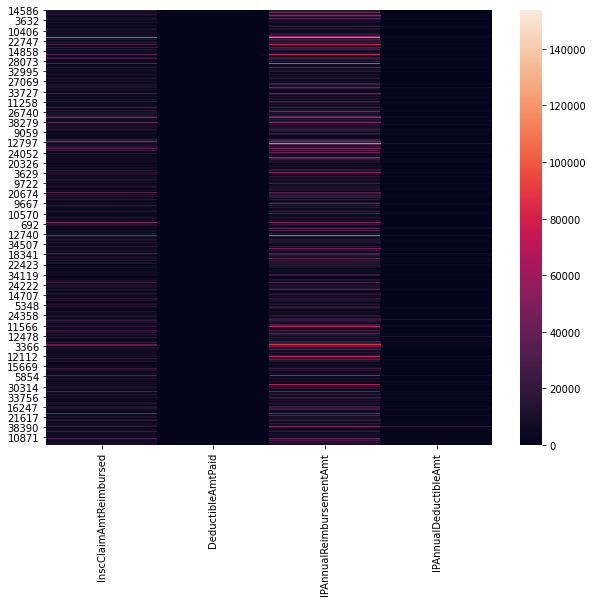

In [21]:
import seaborn as sns
#hmcols = numcols
#hmcols += catcols
#hm = df.loc[:, hmcols]
hm = df.loc[:, numcols]
#get correlations of each features in dataset
corrmat = hm.corr()
top_corr_features = corrmat.index

top_corr_features
plt.figure(figsize=(10,8))
#plot heat map
g=sns.heatmap(hm)

## PCA (Broken)

In [ ]:
# attempt PCA:

# Code from: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
features = df.columns
# Separating out the features
X = df.loc[:, features].values# Separating out the target
Y = df.loc[:,['PotentialFraud_Yes']].values# Standardizing the features
X = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df[['PotentialFraud_Yes']]], axis = 1)

df[['PotentialFraud_Yes']]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['PotentialFraud_Yes','PotentialFraud_No']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['PotentialFraud_Yes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
pca.explained_variance_ratio_


## Unused Section:

In [ ]:
df = ipdata[['ClmProcedureCode_1', 'DiagnosisGroupCode']]
df = df[df['ClmProcedureCode_1'].isna() ]

df[df['DiagnosisGroupCode'].isna() ]



#df[df['DiagnosisGroupCode'] != df['DiagnosisGroupCode']]

In [ ]:

# Merge ICD-9 Procedure Code data with inpatient data to find missing codes:
ipdata = ipdata.merge(proc_codes, left_on='ClmProcedureCode_1', right_on='PROCEDURE CODE', how='left')
ipdata = ipdata.rename(columns={"PROCEDURE CODE": "ProcedureCode_1", "SHORT DESCRIPTION":"ProcedureShortDesc_1", "LONG DESCRIPTION": "ProcedureLongDesc_1"})
ipdata = ipdata.merge(proc_codes, left_on='ClmProcedureCode_2', right_on='PROCEDURE CODE', how='left')
ipdata = ipdata.rename(columns={"PROCEDURE CODE": "ProcedureCode_2", "SHORT DESCRIPTION":"ProcedureShortDesc_2", "LONG DESCRIPTION": "ProcedureLongDesc_2"})
ipdata = ipdata.merge(proc_codes, left_on='ClmProcedureCode_3', right_on='PROCEDURE CODE', how='left')
ipdata = ipdata.rename(columns={"PROCEDURE CODE": "ProcedureCode_3", "SHORT DESCRIPTION":"ProcedureShortDesc_3", "LONG DESCRIPTION": "ProcedureLongDesc_3"})
ipdata = ipdata.merge(proc_codes, left_on='ClmProcedureCode_4', right_on='PROCEDURE CODE', how='left')
ipdata = ipdata.rename(columns={"PROCEDURE CODE": "ProcedureCode_4", "SHORT DESCRIPTION":"ProcedureShortDesc_4", "LONG DESCRIPTION": "ProcedureLongDesc_4"})
ipdata = ipdata.merge(proc_codes, left_on='ClmProcedureCode_5', right_on='PROCEDURE CODE', how='left')
ipdata = ipdata.rename(columns={"PROCEDURE CODE": "ProcedureCode_5", "SHORT DESCRIPTION":"ProcedureShortDesc_5", "LONG DESCRIPTION": "ProcedureLongDesc_5"})

# Merge ICD-9 Diagnosis Code data with inpatient data to find missing codes:
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_1', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_1", "DESCRIPTION": "DiagnosticDesc_1"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_2', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_2", "DESCRIPTION": "DiagnosticDesc_2"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_3', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_3", "DESCRIPTION": "DiagnosticDesc_3"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_4', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_4", "DESCRIPTION": "DiagnosticDesc_4"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_5', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_5", "DESCRIPTION": "DiagnosticDesc_5"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_6', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_6", "DESCRIPTION": "DiagnosticDesc_6"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_7', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_7", "DESCRIPTION": "DiagnosticDesc_7"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_8', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_8", "DESCRIPTION": "DiagnosticDesc_8"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_9', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_9", "DESCRIPTION": "DiagnosticDesc_9"})
ipdata = ipdata.merge(diag_codes, left_on='ClmDiagnosisCode_10', right_on='DIAGC', how='left')
ipdata = ipdata.rename(columns={"DIAGC": "DiagnosticCode_10", "DESCRIPTION": "DiagnosticDesc_10"})


## Data Quality

In [ ]:
ipdata.isnull().sum()

## Simple Statistics

In [ ]:
ipdata.describe()

## Visualize Attributes

## Explore Joint Attributes

## Explore Attributes and Class

## New Features
Column|Description|Calculation
:---|:---|:---
DaysIP | Inpatient Days Stayed | DischargeDt - AdmissionDt + 1


In [ ]:
ipdata['DaysIP'] = ipdata['DischargeDt'] - ipdata['AdmissionDt'] + pd.Timedelta(1, unit='days')


## Exceptional Work

In [ ]:
# Known Fraud Cases: (TODO: add a dictionary or something here with various known scenarios?)

## Number of claims with admission date after death:
((ipdata['AdmissionDt'] - ipdata['DOD']) > pd.Timedelta(1, unit='days')).sum()

# Rubric:
## Business Understanding 	10	
*Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.* 

Class notes:  
- First couple of sentences are straightforward.  MAKE SURE you answer why it's important (why we picked it) what are we going to predict using this dataset? 
- Once you picked it. It will be either continuous or categorical. YOU MUST also identify the algorithm.  I will measure effectiveness of the algorithm using _____RMSE or whatever______ ? 
- Continuous: regression problem RMSE, MAEP (mean absolute error percentage), R^2 (more for CV) 
- Categorical: classification problem.  Could use: accuracy, precision, recall, F1, ROC curve 
- I want to predict X, type of problem, measure effectiveness using ___ cross validation, and metric (precision/recall) 
- Mean absolute error: can predict within X percent of actual graduation rate 
- RMSE: pretty close to MAE, but if model gets something really wrong (true: 90%, predict 70%), RMSE penalizes really heavily for those big misses 

## Data Meaning Type 	10	
*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.*

Class notes:
- Dataframe.info() in pandas.  Can put it in a table and provide definitions (business info) 

## Data Quality	15	
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

Class notes:
- Hit all 6 things for full credit.  Code to check for each.  Boxplots. (don't need a boxplot for all 1000 fields) programmatic effort is ok for large # of fields.  Looking for explanations for why we decided to do something a certain way.  As long as it is explained well, should be full credit unless it is egregious.   

## Simple Statistics	10	
Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful. 

Class notes:
- Dataframe.describe() and pick a couple of interesting fields and describe why interesting 
- What percent belongs to positive vs negative response variable 

## Visualize Attributes	15	
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.

Class notes:
- Two requirements for each viz you make that need to be written about 
- Need more than 1 sentence.  If take time to make viz, explain why we did it, and why it's significant to report 
- Report needs to be equal parts code & writing 

## Explore Joint Attributes	15	
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

Class notes:
- Viz two or more and analyze why they're different 
- Pair plot, or scatterplot for pairwise combos of features 
- Correlation heatmap, talk about highly correlated fields 
- If correlated w/ response woot, if another feature, may need cleanup 

## Explore Attributes and Class	10	
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

Class notes:
- Class = thing in dataset you're trying to predict 
- Ds.data and ds.target (target = response, data = features) 
- Can use visualizations here, Should tie together w/ visualizations  

## New Features	5	
Are there other features that could be added to the data or created from existing features? Which ones?

Class notes:
- Feature engineering, don't have to build them, just think about it and comment on what you might do 
- ML models are really basic, don't see the same things as people see 
- Can bin age/income, or create percentages 
- More info you can tell model, the better 
- If you're going to get some features from somewhere else, you must be explicit:
- I.e. I want to add weather info: where is the data coming from, prove it exists 
- Could be a couple of bullet points with what we're going to create 

## Exceptional Work	10	
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.

Class notes:
- Can pick what you want to work on. PCA. Scree plot, talk about it.  Be creative or smart.  Could build a model (log regression or SVM) for exceptional points, and then cut/paste into lab 2 
- Here are the things I'd like to be considered for exceptional points: if you do code and explain it, should be point worthy.  Needs to be substantial.  I.e. make it good. 